<a href="https://colab.research.google.com/github/nikhelll/Finance-Tidbits/blob/main/Monte_Carlo_Options_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter option type (call or put): ojpewpf
Error: Invalid option type. Use 'call' or 'put'.
Enter option type (call or put): put
Enter current stock price (S): 100
Enter option strike price (K): 110
Enter risk-free interest rate (r): 0.02
Enter time to expiration (in years, T): 0.4
Enter the number of simulation paths: 100


<ipython-input-9-8ab1fae82aa6>:74: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  vol_surface = interp2d(strike_prices, maturities, implied_volatility_data, kind='cubic')
<ipython-input-9-8ab1fae82aa6>:92: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

      

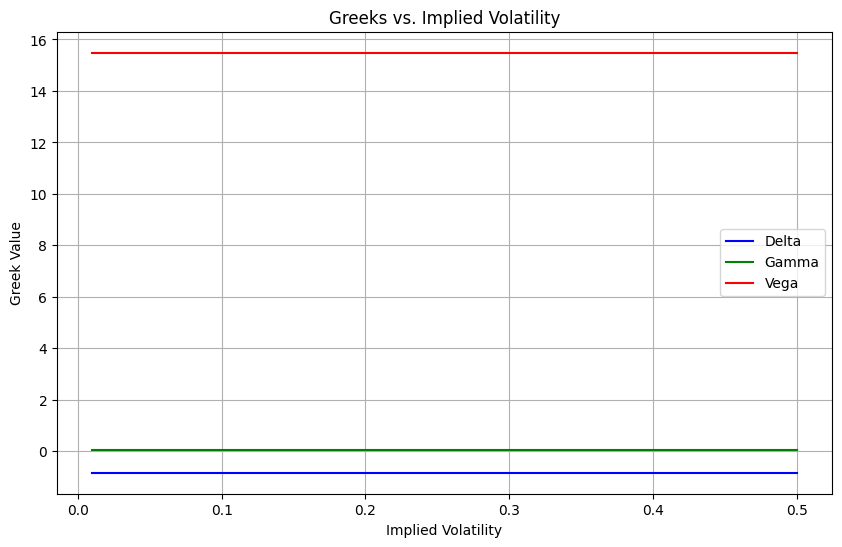

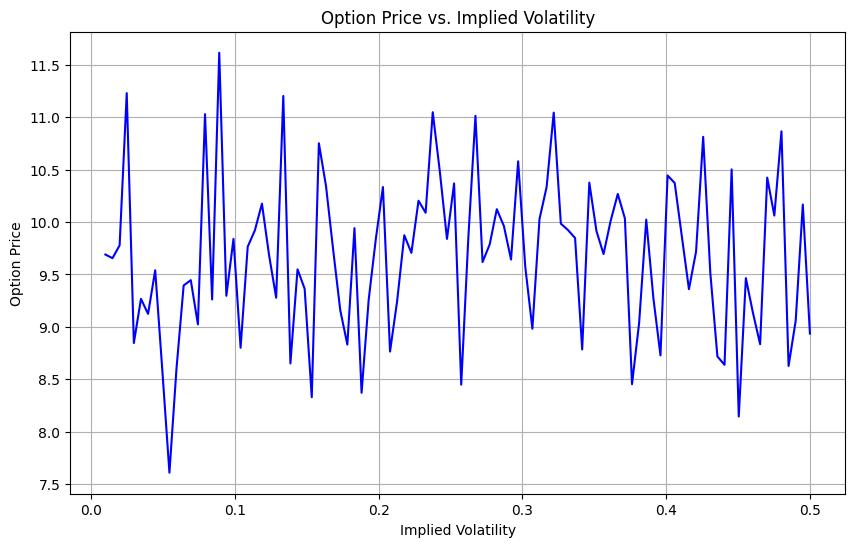

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp2d

def calculate_greeks(S, K, r, sigma, T, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        delta = norm.cdf(d1)
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        vega = S * norm.pdf(d1) * np.sqrt(T)
    elif option_type == 'put':
        delta = norm.cdf(d1) - 1
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        vega = S * norm.pdf(d1) * np.sqrt(T)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    return delta, gamma, vega

def monte_carlo_options_pricer(option_type, S, K, r, implied_volatility, T, num_paths, num_steps):
    dt = T / num_steps
    drift = np.exp((r - 0.5 * implied_volatility ** 2) * dt)
    prices = np.zeros((num_paths, num_steps + 1))
    prices[:, 0] = S

    for i in range(num_paths):
        for j in range(1, num_steps + 1):
            z = np.random.normal(0, 1)
            prices[i, j] = prices[i, j - 1] * drift * np.exp(implied_volatility * np.sqrt(dt) * z)

    if option_type == 'call':
        payoffs = np.maximum(prices[:, -1] - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - prices[:, -1], 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price, prices

def get_user_input():
    try:
        option_type = input("Enter option type (call or put): ").lower()
        if option_type not in ['call', 'put']:
            raise ValueError("Invalid option type. Use 'call' or 'put'.")
        S = float(input("Enter current stock price (S): "))
        K = float(input("Enter option strike price (K): "))
        r = float(input("Enter risk-free interest rate (r): "))
        T = float(input("Enter time to expiration (in years, T): "))
        num_paths = int(input("Enter the number of simulation paths: "))
        num_steps = 252  # Setting num_steps to 252
        return option_type, S, K, r, T, num_paths, num_steps
    except ValueError as e:
        print(f"Error: {e}")
        return get_user_input()

def get_vol_surface():
    # Sample implied volatility data (you can replace this with your actual data)
    strike_prices = [90, 95, 100, 105, 110]
    maturities = [0.25, 0.5, 0.75, 1.0, 1.5]
    implied_volatility_data = [
        [0.2, 0.18, 0.16, 0.15, 0.14],
        [0.19, 0.17, 0.15, 0.14, 0.13],
        [0.18, 0.16, 0.14, 0.13, 0.12],
        [0.17, 0.15, 0.13, 0.12, 0.11],
        [0.16, 0.14, 0.12, 0.11, 0.10]
    ]

    # Create 2D spline interpolation for the volatility surface
    vol_surface = interp2d(strike_prices, maturities, implied_volatility_data, kind='cubic')
    return vol_surface

# Get user input for parameters with exception handling
option_type, S, K, r, T, num_paths, num_steps = get_user_input()

# Get the volatility surface using 2D spline interpolation
vol_surface = get_vol_surface()

# Create a range of implied volatility values
implied_volatility_range = np.linspace(0.01, 0.5, 100)

# Calculate Greeks and option prices using interpolated implied volatility
deltas = []
gammas = []
vegas = []
option_prices = []
for implied_volatility in implied_volatility_range:
    interpolated_volatility = vol_surface(K, T)[0]
    option_price, _ = monte_carlo_options_pricer(option_type, S, K, r, interpolated_volatility, T, num_paths, num_steps)
    delta, gamma, vega = calculate_greeks(S, K, r, interpolated_volatility, T, option_type)
    deltas.append(delta)
    gammas.append(gamma)
    vegas.append(vega)
    option_prices.append(option_price)

# Plot Greeks against implied volatility
plt.figure(figsize=(10, 6))
plt.plot(implied_volatility_range, deltas, label='Delta', color='b')
plt.plot(implied_volatility_range, gammas, label='Gamma', color='g')
plt.plot(implied_volatility_range, vegas, label='Vega', color='r')
plt.xlabel('Implied Volatility')
plt.ylabel('Greek Value')
plt.legend()
plt.title('Greeks vs. Implied Volatility')
plt.grid(True)
plt.show()

# Plot option price against implied volatility
plt.figure(figsize=(10, 6))
plt.plot(implied_volatility_range, option_prices, label='Option Price', color='b')
plt.xlabel('Implied Volatility')
plt.ylabel('Option Price')
plt.title('Option Price vs. Implied Volatility')
plt.grid(True)
plt.show()